<h1>Training a Classifier</h1>

<h3>Author: Aleš Suchomel</h3>

The goal of this notebook is to demonstrate the processing of specified linearly divisible data (2D points) and their classification by implementing a simple Perceptron algorithm. Further, the thesis contains an elementary testing of the created Perceptron, its comparison with freely available algorithms and at the end the paper also deals briefly with the specified non-linearly separable data.

<h3>Preparation</h3> 

First, list of imported libraries and URLs of processed files:

In [1]:
#Reading csv files
import csv
#Computing and containers
import numpy as np
#Plotting
import matplotlib
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
%matplotlib inline
#Pro SVM Classificator 
import sklearn.svm as svm
#Data presentation
import pandas as pd

In [2]:
#CSV files with the data
linSepDataFileURL = 'linsep-traindata.csv'
linSepClassFileURL = 'linsep-trainclass.csv'

nonLinSepDataFileURL = 'nonlinsep-traindata.csv'
nonLinSepClassFileURL = 'nonlinsep-trainclass.csv'

<h3>Processing of the data</h3>

So, we need to load the provided data from csv files.

In [4]:
def loadDataFromCSVFile(fileURL):    
    dataFile = open(fileURL)   
    dataReader = csv.reader(dataFile)
    data = list(dataReader)
    data = np.array(data).astype("float")
    dataFile.close() 
    return data

linSepData = loadDataFromCSVFile(linSepDataFileURL)
linSepClasses = loadDataFromCSVFile(linSepClassFileURL) 

Then we should print the points in order to make it clear that the loading function works.

In [5]:
df = pd.DataFrame(np.append(linSepData, linSepClasses, axis=1), columns=['X1','X2','class'])
pd.set_option('display.max_columns',17)
display(df.T)

,0,1,2,3,4,5,6,7,...,92,93,94,95,96,97,98,99
X1,2.0009,4.845700,4.17110,1.4660,6.05990,1.3872,0.57898,0.41096,...,-4.6567,-4.4480,-5.1088,-2.5519,-4.1622,-3.2379,-4.3434,-4.2989
X2,4.6848,0.076542,0.50986,5.8026,0.84003,7.3061,1.86560,4.43820,...,-4.8184,-3.7235,-2.7171,-3.4786,-3.5400,-2.3194,-3.4183,-3.7629
class,-1.0000,-1.000000,-1.00000,-1.0000,-1.00000,-1.0000,-1.00000,-1.00000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


As we can see from the table above, those data are already divided by the classes. Because our algorithm may dependend on the order of points in the field, it may be more appropriate to mix the points first.

In [7]:
def shufflePoints(points, classes, seed = 'no'):
    helpField = np.append(points, classes, axis=1)
    rand = np.random
    if seed != 'no':
        rand.seed(seed)
    rand.shuffle(helpField)
    points = helpField[:,0:2]
    classes = helpField[:,2,None]
    return points, classes

linSepData, linSepClasses = shufflePoints(linSepData, linSepClasses, 5)

However, it is best to make a plot to get a better overview.

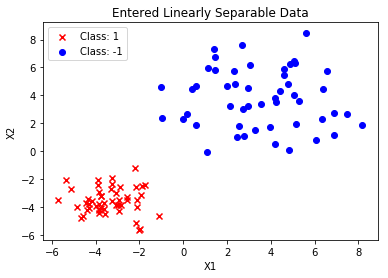

In [20]:
def plotPoints(points, classes):

    X1 = points[classes[:,0]==1,:]
    X2 = points[classes[:,0]==-1,:]
    
    plt.scatter(X1[:,0],X1[:,1], c='r', marker='x', label='Class: 1')
    plt.scatter(X2[:,0],X2[:,1], c='b', marker='o', label='Class: -1')
          
    plt.legend(loc='upper left')
    plt.xlabel('X1')
    plt.ylabel('X2')
    
plt.title('Entered Linearly Separable Data')   
plotPoints(linSepData, linSepClasses) 
plt.show()

<h3>My Perceptron</h3> 

At this stage, we have the points and we can display them. So we can start classifying them. For this purpose, we will create our own class. We will do it in such a way, that the class will implement the same interface as built-in perceptrons in the sklearn library. It will be usefull further.

In [10]:
class myPerceptron:
    # eta:              learning rate
    # MAX_ITERATIONS:   maximal number of epochs
    # weights:          the trained values, a constant and a normal vector to the searched boundary
    
    # Constructor, not very interesting    
    def __init__(self, eta = 0.1, MAX_ITERATIONS = 1000):
        self.eta = eta
        self.MAX_ITERATIONS = MAX_ITERATIONS
        self.weights = np.zeros(3)
        
    # predict
    #
    # Predict is the point classification function, which assigns points to the classes based on the learned weights.
    #
    # Inputs
    # points:    array of points for classification
    #
    # Outputs
    # Z:         array of identified classes, each class is in the same row in Z as the relevant point in array points
    def predict(self, points):
        Z = []
        if len(points.shape)<=1:
            points=[points]
        for row in points:
            xx = np.array([float(-1),row[0],row[1]])
            value = np.sum(self.weights*xx)  
            if value > 0: 
                Z.append(-1)
            else:
                Z.append(1)    
        return np.array(Z)

    # countErrors
    #
    # CountErrors is a function, which returns the number of poorly classified training points by the perceptron.
    #
    # Inputs
    # points:        array of points for classification
    # classes:       array of classes of training points
    #
    # Outputs
    # errors:        the number of errors (identified class is different from the correct one)
    def countErrors(self, points, classes):
        errors = 0
        ind = 0
        for p in points:
            guessedClass = self.predict(p)
            errors += abs((guessedClass - classes[ind])/2)
            ind += 1
        return int(errors)   

    # fit
    #
    # Fit is the function, which trains the weights, uses the Stochastic gradient descent algorithm to do so.
    #
    # Inputs
    # trainPoints:  array of points for classification
    # classes:      array of classes of training points
    #
    def fit(self, trainPoints, classes):
        self.weights = np.zeros(3)
        errors = 1
        index = 0
        while index < self.MAX_ITERATIONS and errors != 0:
            indexClass = 0
            for p in trainPoints:
                guessedClass = self.predict(p)
                error = (guessedClass[0] - classes[indexClass])/2
                xx = np.array([float(-1),p[0],p[1]])
                self.weights += xx*error*self.eta         
                indexClass+=1
            index += 1
            errors = self.countErrors(trainPoints,classes)
            
my = myPerceptron()
my.fit(linSepData, linSepClasses)

    

Number of wrongly classified training points: 0


The myPerceptron class allows us to classify the specified points and, according to the result of the countErrors function, it can assign them to the correct class. This means we have found a line that divides the two sets of points. However, in order to have a better knowladge, we should create a graph again.

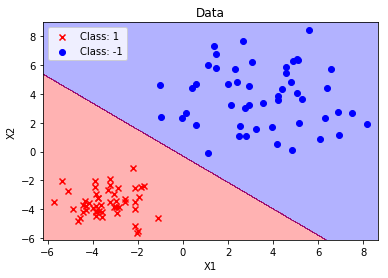

In [12]:
# The basic idea of the next function comes from
def plotClassification(points, classes, classifier):
 
    colors = ('blue','red')
    step = 0.02

    x0Min = points[:,0].min() - 0.5 
    x0Max = points[:,0].max() + 0.5
    x1Min = points[:,1].min() - 0.5
    x1Max = points[:,1].max() + 0.5
    
    x0 = np.arange(x0Min, x0Max, step)
    x1 = np.arange(x1Min, x1Max, step)
    xx0, xx1 = np.meshgrid(x0,x1)

    allX = np.array([xx0.ravel(), xx1.ravel()]).T
    Z = classifier.predict(allX)
    Z = Z.reshape(xx0.shape)
    
    plt.contourf(xx0, xx1, Z, alpha = 0.3, colors = colors)   
    plotPoints(points, classes)
    
plotClassification(linSepData, linSepClasses, my) 
plt.show()

So we managed to divide the data, but that does not mean that our algorithm works properly. Moreover, the data seems relatively straightforward to be linearly separable. For better testing of our algorithm we will need to generate new linearly separable points.

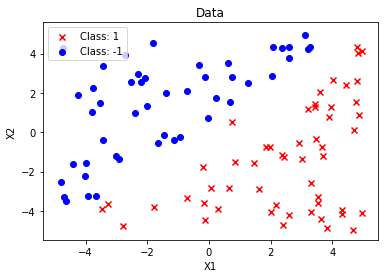

In [13]:
def generateLinSepData(a = 1, b = 0, nData = 100, minDistance = 0.1, seed = 'no'):    
    
    rand = np.random
    if seed != 'no':
        rand.seed(seed)        
    data = rand.random([nData,2]) * 10 - 5
        
    x1Distance = a * data[:,0,None] + b - data[:,1,None]
    x1Conditions = [x1Distance <= -minDistance, x1Distance >= minDistance, abs(x1Distance)<minDistance]
    x1Classes = np.select(x1Conditions,[-1, 1, 0])
    
    x2Distance = (data[:,1,None] - b) / a - data[:,0,None]
    x2Conditions = [abs(x2Distance)<minDistance, abs(x2Distance)>=minDistance]
    x2Classes = np.select(x2Conditions,[0,1])    
    classes = np.multiply(x1Classes,x2Classes)
    
    data = data[classes[:,0]!=0]
    classes = classes[classes[:,0]!=0]
    
    return(data,classes)

randomData,randomClasses = generateLinSepData()
plotPoints(randomData,randomClasses)
plt.show()

When we are able to generate the data, we only have to write a function that will generate random sets of the points and also parametrs of dividing lines in cycles. The function should also count a number of poorly classified points and present the results.

In [14]:
def classificatorTest(classifier, iterations = 100, nData = 100, minDistance = 0.1):
    
    errors = 0
    errorSamplesList = []
    r = np.random
    for i in range(iterations):
        a = r.random() * 20 - 10
        b = r.random() * 10 - 5
        randomData, randomClasses = generateLinSepData(a,b, minDistance = minDistance, nData = nData)
        classifier.fit(randomData, randomClasses)
        er = classifier.countErrors(randomData, randomClasses)           
        if er != 0:
            errors += er
            print('Incorrect classification of ' + str(er) + 'points was observed.')
            plotClassification(randomData, randomClasses, classifier)
            plt.show()
            errorSamplesList.append([randomData, randomClasses])
            
    Text1 = 'A perceptron test was performed. There were ' + str(iterations) \
            + ' training sets of ' + str(nData) + ' randomly generated linearly separable points. \n'
    print(Text1)
    if errors == 0:
        Text2 = 'During the test, no point was badly classified. \n' 
    else:
        Text2 = 'Overall, there occured ' + str(errors) + ' errors. The samples with incorrect' \
        + ' classification are shown above. \n'
    print(Text2)
    return (errorSamplesList)
erList = classificatorTest(myPerceptron())    

A perceptron test was performed. There were 100 training sets of 100 randomly generated linearly separable points. 

During the test, no point was badly classified. 



So it looks like our algorithm really works. It can divide two linearly separable sets with only a small distance between them.

<h3>The quality of the solution</h3>

We have showed that we can find the dividing line. Of course, there is not only one solution to this task. So, can we find a good solution? Probably not, our algorithm only looks for a permissible solution. To find a good solution, we should use a different algorithm. An interesting example is Support vector machine that maximizes the minimum distance of points from the dividing line. We will not implement it anymore, but we can show a solution to our problem with the a perceptron from sklearn library.

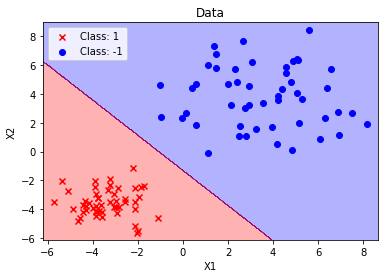

In [15]:
linearSVM = svm.SVC(kernel = 'linear') 
linearSVM.fit(linSepData, linSepClasses[:,0])
plotClassification(linSepData, linSepClasses,linearSVM) 
plt.show()

<h3>Advanced option - Linear non-separable data</h3>

There is no difference in processing. We can use the same functions as before.


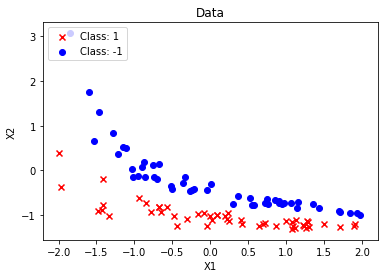

In [16]:
dataNon = loadDataFromCSVFile(nonLinSepDataFileURL)
classNon = loadDataFromCSVFile(nonLinSepClassFileURL)
shufflePoints(dataNon, classNon, 5)
plotPoints(dataNon, classNon)      
plt.show()

Our perceptron worked very well on linearly separable data, where it theoretically converges to the right solution.
However, it is absolutely unusable for linearly non-separable points as shown below.

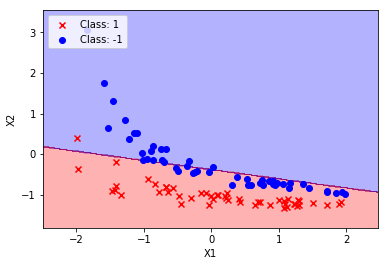

Number of wrongly classified training points: 30


In [21]:
my = myPerceptron()
my.fit(dataNon, classNon)
plotClassification(dataNon, classNon,my)
plt.show()    
print('Number of wrongly classified training points: ' + str(my.countErrors(dataNon, classNon)))

The algorithm borrowed from the library can by used for linearly inseparable, eg due to noise, data. His solution to the second problem is much better. Only a few points are poorly qualified.

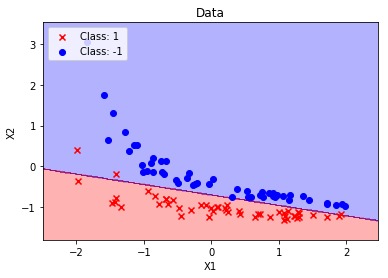

In [18]:
linear = svm.SVC(kernel='linear') 
linear.fit(dataNon, classNon[:,0])
plotClassification(dataNon, classNon,linear)
plt.show()

Of course, it is not the best solution to fit the specified non-linearly separable data with a straight line. A much better solution is to transform the data using a kernel function into those that are linearly separable first and then classify them. This solution is demonstrated below using the same library as before.

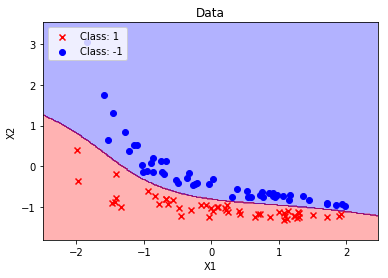

In [19]:
mod = svm.SVC(kernel='rbf', random_state=0, gamma=0.5, C=10)
mod.fit(dataNon, classNon[:,0])
plotClassification(dataNon, classNon, mod)

Conclusion

.. in process...

<h3>Citace</h3>

https://jtsulliv.github.io/perceptron/ <br>
https://pdfs.semanticscholar.org/6174/3124c2a4b4e550731ac39508c7d18e520979.pdf<br>
https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/<br>
http://www.3dmatics.com/blog/2014/11/artificial-linearly-separable-test-data-in-python/<br>
https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/<br>
ta knihovna
+ wikipedie ruzne
